In [78]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from matplotlib.colors import LogNorm


In [79]:
#checking the vaildity of the source plane map
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from lenstronomy.LensModel.convergence_integrals import deflection_from_kappa_grid 

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 280, 'center_y': 320}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size, 679), np.linspace(0, size, 679))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)



6


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


172 429 277


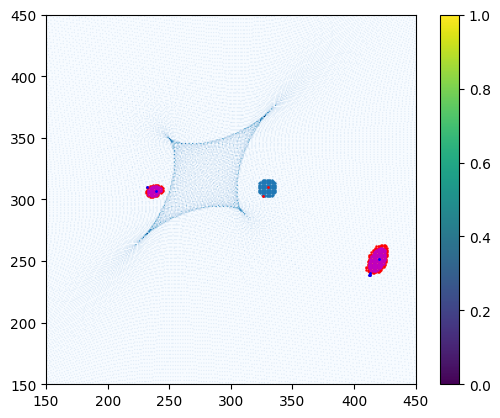

In [140]:
array_test2 = np.zeros([678,678])

img_coord_in_src_coord = [[[] for _ in range(678)] for _ in range(678)]
# integer search method
for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        #array_test2[yceil,xceil] += 1 #data_img[i,j]*ydec*xdec
        #array_test2[yceil,xfloor] += 1 #data_img[i,j]*ydec*(1-xdec)
        #array_test2[yfloor,xceil] += 1 #data_img[i,j]*(1-ydec)*xdec
        if i%3==0 and j%3==0:
            array_test2[yfloor,xfloor] += 1 #data_img[i,j]*(1-ydec)*(1-xdec)
        img_coord_in_src_coord[yfloor][xfloor].append([i,j])
        #img_coord_in_src_coord[yfloor][xceil].append([i,j])
        #img_coord_in_src_coord[yceil][xfloor].append([i,j])
        #img_coord_in_src_coord[yceil][xceil].append([i,j])
       

# gaussian circle
mean = [330, 310]
cov = [[40, 0], [0, 40]]

x, y = np.meshgrid(np.linspace(0, size, size), np.linspace(0, size, size))

# Generate a 2D Gaussian distribution over the grid
d = np.dstack([x, y])
gaussian_circle = np.exp(-0.5 * (np.einsum('...k,kl,...l->...', d - mean, np.linalg.inv(cov), d - mean)))
circle_coords = np.argwhere(gaussian_circle > 0.5) #(y,x)
intensity = []

# radius
from scipy.ndimage import distance_transform_edt as distance
radius = max(circle_coords[:,1])-mean[0]
print(radius)

scatterx, scattery = [], []
n=0
plt.imshow(array_test2, cmap='Blues',vmax=10)

plt.scatter(circle_coords[:,1],circle_coords[:,0],s=0.5)

for (i,j) in circle_coords:
    
    for point in img_coord_in_src_coord[i][j]:
        n+=1
        scatterx.append(point[1])
        scattery.append(point[0])
        
plt.scatter(scatterx,scattery,s=0.5, c='r')

m=0
scatterx, scattery = [], []
#specific method for perfect circle
for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j]
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        dist = np.sqrt((ycoord-mean[1])**2+(xcoord-mean[0])**2)
        if dist <= radius:
            scatterx.append(j)
            scattery.append(i)
            m+=1
            
            
plt.scatter(scatterx,scattery,s=0.5, c='m')        


# distance of images from their respective centers
distances = distance(img_coord_in_src_coord)

plt.scatter([330,circle_coords[0,1]],[310,circle_coords[0,0]],s=1, c='r')

for point in img_coord_in_src_coord[310][330]:
    plt.scatter(point[1],point[0],s=1, c='b')
for point in img_coord_in_src_coord[circle_coords[0,0]][circle_coords[0,1]]:
    plt.scatter(point[1],point[0],s=1, c='b')
    
plt.xlim(150,450)
plt.ylim(150,450)

plt.colorbar()
print(len(circle_coords), n, m)


In [108]:
from scipy.ndimage import distance_transform_edt as distance
'''# square ugly source
source_x = np.linspace(295, 304, 10)
source_y = np.linspace(315, 324, 10)
source_x, source_y = np.meshgrid(source_x, source_y)
source_x_1d = source_x.ravel()
source_y_1d = source_y.ravel()
# circle source
size = 680
radius = 7
center = [300,320]
# Create a 2D grid of points
x, y = np.meshgrid(np.arange(size), np.arange(size))

# Calculate the distance of each point from the center of the array
distances = distance((x - center[0])**2 + (y - center[1])**2)

# Create a binary mask where points inside the circle are 1 and points outside the circle are 0 given the center coordinates
circle = (distances < radius).astype(int)
circle_coords = np.argwhere(circle == 1)'''





'# square ugly source\nsource_x = np.linspace(295, 304, 10)\nsource_y = np.linspace(315, 324, 10)\nsource_x, source_y = np.meshgrid(source_x, source_y)\nsource_x_1d = source_x.ravel()\nsource_y_1d = source_y.ravel()\n# circle source\nsize = 680\nradius = 7\ncenter = [300,320]\n# Create a 2D grid of points\nx, y = np.meshgrid(np.arange(size), np.arange(size))\n\n# Calculate the distance of each point from the center of the array\ndistances = distance((x - center[0])**2 + (y - center[1])**2)\n\n# Create a binary mask where points inside the circle are 1 and points outside the circle are 0 given the center coordinates\ncircle = (distances < radius).astype(int)\ncircle_coords = np.argwhere(circle == 1)'

In [109]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver


# solve by fansy package
solver = LensEquationSolver(lensModel)
image_x = []
image_y = []
intensity = []
for i in range(0, len(circle_coords)):
    x = circle_coords[i,1]
    y = circle_coords[i,0]
    theta_x, theta_y = solver.image_position_analytical(x=x, y=y, kwargs_lens=kwargs_lens)
    image_x.append(theta_x)
    image_y.append(theta_y)
    intensity.extend([gaussian_circle[y,x]]*len(theta_x))
    

'''image_x_sq = []
image_y_sq = []
for i in range(0, 10):
    for j in range(0, 10):
        x = source_x[i,j]
        y = source_y[i,j]
        theta_x, theta_y = solver.image_position_analytical(x=x, y=y, kwargs_lens=kwargs_lens)
        image_x_sq.append(theta_x)
        image_y_sq.append(theta_y)'''
        


# make image_x in a 1d array
image_x_1d = np.concatenate(image_x)
image_y_1d = np.concatenate(image_y)
image = np.array(np.meshgrid(image_x_1d, image_y_1d))

#using scatter plot for all maybe?
circle_graph = gaussian_circle * 10
intensity = np.array(intensity)
intensity_graph = intensity / 2

 
graph = circle_graph + array_test2

'''plt.imshow(graph, cmap='Blues')
plt.scatter(image_x_1d, image_y_1d, color='red', s=1, alpha=intensity_graph)

plt.xlim(150,450)
plt.ylim(150,450)

#calculate the magnification'''


"plt.imshow(graph, cmap='Blues')\nplt.scatter(image_x_1d, image_y_1d, color='red', s=1, alpha=intensity_graph)\n\nplt.xlim(150,450)\nplt.ylim(150,450)\n\n#calculate the magnification"

(150.0, 450.0)

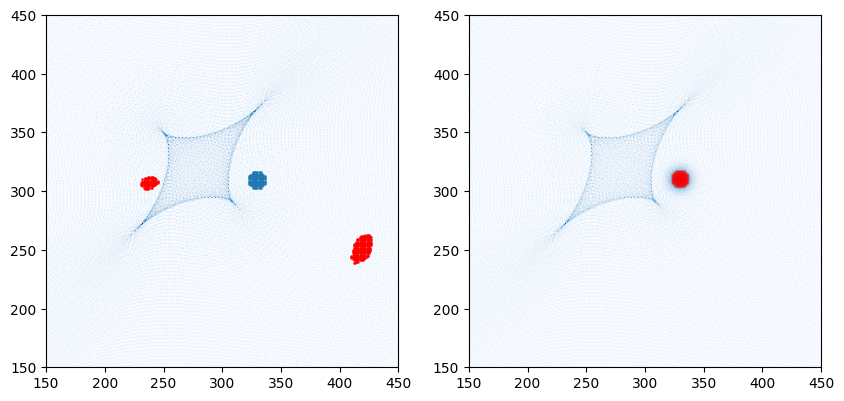

In [111]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(array_test2, cmap='Blues',vmax=10)
ax[0].scatter(circle_coords[:,1],circle_coords[:,0],s=0.5)
for (i,j) in circle_coords:
    for point in img_coord_in_src_coord[i][j]:
        ax[0].scatter(point[1],point[0],s=0.5, c='red')

#ax[0].gca().invert_yaxis()
ax[0].set_xlim(150,450)
ax[0].set_ylim(150,450)

ax[1].scatter(image_x_1d, image_y_1d, color='red', s=1, alpha=intensity_graph) 
graph = circle_graph + array_test2

ax[1].imshow(graph, cmap='Blues')

#ax[1].gca().invert_yaxis()
ax[1].set_xlim(150,450)
ax[1].set_ylim(150,450)

In [112]:
#maginification
for i in range(0, len(circle_coords)):
    x = circle_coords[i,1]
    y = circle_coords[i,0]
    mag = lensModel.magnification(x=x, y=y, kwargs = kwargs_lens)
    print(mag)



1.0024830600281551
1.0024813782044195
1.0024780364860648
1.0024735761412895
1.002471338578248
1.0024674395943218
1.0024640867545307
1.0024618588168326
1.0024802704340818
1.002478597869795
1.0024769181092363
1.0024735746022042
1.0024691100793957
1.0024663204669604
1.0024629756241048
1.002459626651561
1.0024562815845857
1.0024546036607975
1.0024808248215547
1.0024774775531322
1.0024730167773086
1.0024713367437406
1.0024685509266402
1.0024657615613373
1.0024613009795826
1.0024573963628916
1.0024551662835695
1.002448477572922
1.0024495838355536
1.0024456832694246
1.0024780412086527
1.002474693878923
1.0024746826742323
1.0024696665175645
1.0024663247924401
1.0024635314906274
1.0024601844423555
1.0024557238817438
1.0024529325490055
1.0024484777054565
1.002446799716753
1.0024445644377455
1.0024401041201823
1.0024362015209523
1.0024730179292989
1.002471341608096
1.0024663251776704
1.0024640928624473
1.0024640860744969
1.002457398321214
1.0024562742405836
1.0024523752010468
1.0024501418152127
1

(0.0, 600.0)

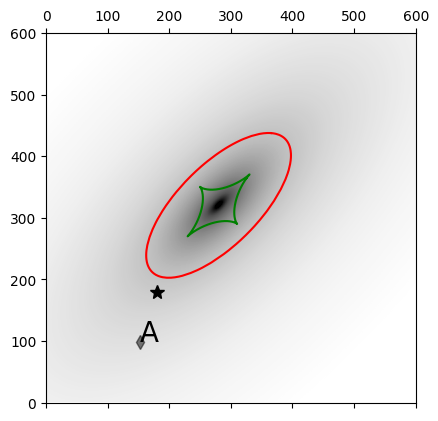

In [8]:
from lenstronomy.Plots import lens_plot

f, ax = plt.subplots()
src_x, src_y = 180,180

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens,numPix=5000, deltaPix=0.25, sourcePos_x=src_x, sourcePos_y=src_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=True)
# make the plot to have 679x679 pixels
plt.xlim(0,600)
plt.ylim(0,600)

277


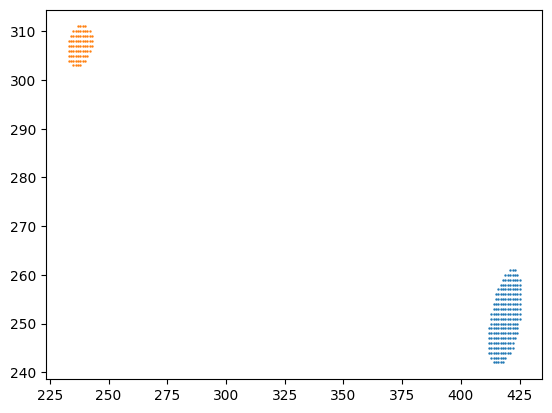

In [123]:
#maginification
from sklearn.cluster import DBSCAN
coordinates = []
for i in range(0, len(scatterx)):
    coordinates.append([scatterx[i], scattery[i]])
coordinates = np.array(coordinates)

# Apply DBSCAN clustering
# eps and min_samples need to be chosen based on your specific data
dbscan = DBSCAN(eps=10, min_samples=50).fit(coordinates)

# Extract labels
labels = dbscan.labels_

# Separate coordinates into arrays for each image
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]

# images now contains separate arrays for each detected image
#for image, coords in images.items():
    #print(f"{image}: {coords}")
for i in range(0, len(images)):
    plt.scatter(images[f'Image_{i}'][:,0], images[f'Image_{i}'][:,1], s=0.5)
print(len(images[f'Image_{0}'])+len(images[f'Image_{1}']))